
We made experiments on the data from {AD}. It consists of Reddit posts in English categorized into 10 topics: science, politics, history, space and astronomy, Minecraft video game, sexual activities, guns, food and cooking, music and motorcycles. In each class there is 100 posts in the database. The first 9 categories were treated as positive samples, while motorcycles as the anomalies. 



The training set constitutes $90\%$ of comments from positive classes, they are selected randomly without assuming the equality of categories. The test collection consists of the remaining $ 10\% $ of posts from positive classes and 100 comments from the category of motorcycles. So we have $52\%$ of the anomaly in the test set.
The accuracy metric was used for evaluation as the test set had almost the same number of inliers as outliers, and the authors of {AD} also used this metric.



On the picture on the right there is a schema of the pipeline we used in our experiment.

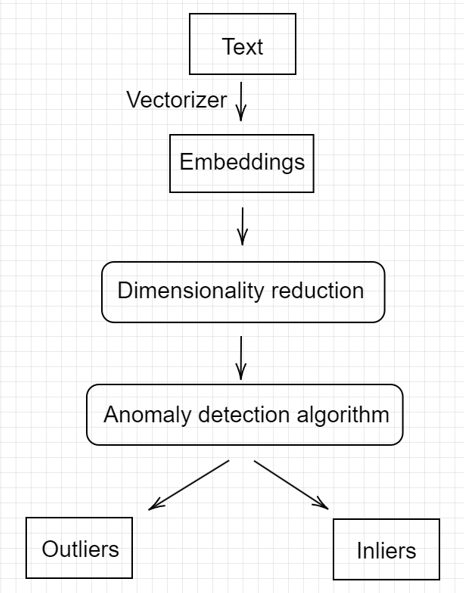


Let us briefly list the tools we have used. For embedding three methods of text vectorization were checked: word2vec -- the same that the authors {AD} took, BERT {BE} and the method proposed in {DU} - deep feature from BiLSTM network on top of GLOVE. For dimension reduction PCA and UMAP were checked. For finding outliers the following algorithms were used: Isolation Forest, DBSCAN, Local Otlier Factor, One Class SVM, Autoencoders with different inner networks (Dense, LSTM, BiLSTM, GRU and CNN were tested with different parameters) and the methods from {AD} - Threshold for Standard deviation error from classifier prediction. Additionally different classifiers were checked, including neural networks. 

Unfortunately, dimension reduction did not improve the results but even made it significantly worse. Therefore we decided to omit this step in the final version of our pipeline. Let us present the table with accuracy for all combinations (we highlighted the best results in the accuracy column):

In each case, the dimensions were reduced to two, perhaps reducing to a higher number would produce better results. In addition, there are still many possibilities to improve the results. Starting from testing other algorithms to text vectorization and ending with changing anomaly detection algorithms.


{AD} Amir Bakarov, Ilya Sochenkov, Vasiliy Yadrintsev: \emph{Anomaly Detection for Short Texts, St. Petersburg, Russia, May 2018}

{BE} Jacob Devlin Ming-Wei Chang Kenton Lee Kristina Toutanova: \emph{BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding, 2018}

{DB} Martin Ester, Hans-Peter Kriegel, Jiirg Sander, Xiaowei Xu: \emph{A Density-Based Algorithm for Discovering Clusters
in Large Spatial Databases with Noise, 1996}

{DU} Ting-En Lin, Hua Xu: \emph{Deep Unknown Intent Detection with Margin Loss, 2019}

{IS} Fei Tony Liu, Kai Ming Ting, Zhi-Hua Zhou: \emph{Isolation Forest, 2008}

{WV} Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, Jeffrey Dean: \emph{Distributed Representations of Words and Phrases
and their Compositionality, 2013}

{LE} Xin Rong: \emph{word2vec Parameter Learning Explained, 2016}

{trees} Sartaj Sahni, \textit{Data Structures, Algorithms, and Applications in C++}, Silicon Press, 2nd edition, 2004.

{CD} \textit{“Curse of dimensionality”} Wikipedia, Wikimedia Foundation, 1 August 2022, \url{ https://en.wikipedia.org/wiki/Curse\_of\_dimensionality}

# Imports

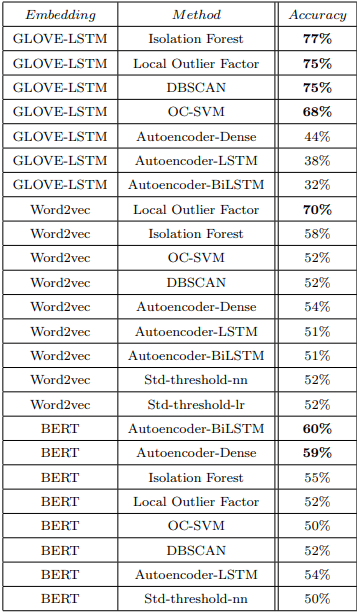

In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 8.2 MB 43.4 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=199c7646d642f4805ab4bc1e28737718e0022bf01ca0f8790d40ebb1c2a06c14
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [ ]:
from sklearn.metrics import f1_score
from pandas import DataFrame, concat
from gensim.models import KeyedVectors, Word2Vec
from pathlib import Path
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, make_scorer, f1_score, precision_score
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from gensim import corpora, models
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from pylab import get_cmap
import seaborn

from os import path, makedirs
from itertools import combinations
from re import sub, compile

import pickle
from scipy import stats
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
from sklearn.metrics import accuracy_score
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

from gensim.models import Word2Vec, KeyedVectors
from numpy import average, array

from google.colab import drive

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# class - vectorizer()

In [ ]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from pymorphy2 import MorphAnalyzer
from gensim.models import Word2Vec, KeyedVectors
from numpy import average, array

DVACH = '2ch'
REDDIT = 'reddit'
MTS = 'mts'

DATA = REDDIT
COMMENT = 'comment'
if DATA == REDDIT:
    LANG = 'en'
else:
    LANG = 'ru'



RU = 'ru'
EN = 'en'

class Vectorizer:

    def __init__(self, lang=EN):
        self._lang = lang
        self._tokenizer = self.set_tokenizer()
        self._stop = self.set_stop()
        self._lemmer = self.set_lemmer()
        self._model = self.set_w2v_model()
        self._vocab = self.set_w2v_vocab()

    def set_tokenizer(self):
        if self._lang == EN:
            return RegexpTokenizer('[A-Za-z]\w+')
        elif self._lang == RU:
            return RegexpTokenizer('[A-ZА-Яa-zа-я]\w+')


    def set_lemmer(self):
        if self._lang == EN:
            return WordNetLemmatizer()
        elif self._lang == RU:
            return MorphAnalyzer()


    def set_stop(self):
        if self._lang == EN:
            return stopwords.words('english')
        elif self._lang == RU:
            return stopwords.words('russian')


    def set_w2v_model(self):
        if self._lang == EN:
            from google.colab import drive
            drive.mount('/content/gdrive')
            import sys
            sys.path.insert(0,'/content/gdrive/My Drive/Praca_Licencjacka/models')
            return KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Praca_Licencjacka/models/google_news.bin', binary=True)
        elif self._lang == RU:
            return Word2Vec.load('2ch_model')

    def set_w2v_vocab(self):
        if self._lang == EN:
            return self._model.vocab
        elif self._lang == RU:
            return self._model.wv.vocab


    def __morph__(self, word):
        if self._lang == EN:
            return self._lemmer.lemmatize(word.lower())
        elif self._lang == RU:
            return self._lemmer.parse(word.lower())[0].normal_form

    def morph_sentence(self,    sent):
        return [self.__morph__(word) for word in self._tokenizer.tokenize(sent)
            if word.lower() not in self._stop]

    def make_vectors(self, t):
        t = [str(document) for document in t]
        k = [[self.__morph__(word) for word
              in self._tokenizer.tokenize(document) if word.lower()
              not in self._stop]
              for document in t]
        vectors = [[self._model[word] for word in sent if word in self._vocab] for sent in k]
        return array([average(vector,axis=0) for vector in vectors if vector])


In [ ]:
vc = Vectorizer(LANG)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Preparing DataFrames

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
UNKNOWN_CLASS = 'UNKNOWN'

appended_data = []
for name in range(9):
        df = pd.read_csv('/content/gdrive/My Drive/Praca_Licencjacka/reddit-topics/{}.csv'.format(name))
        appended_data.append(df)
data = pd.concat(appended_data)

data_an = pd.read_csv('/content/gdrive/My Drive/Praca_Licencjacka/reddit-topics/{}.csv'.format(9))


In [ ]:
data

,Unnamed: 0,comment
0,0,grown with ecm extra cellular matrix 60 minute...
1,1,they had a gun shot victim treated with the st...
2,2,in your body well they can take a lot of white...
3,3,wherever and it heals they also took out a guy...
4,4,make my living harvesting grain with a scythe...
...,...,...
95,95,pork neck bones you can use ribs cut into indi...
96,96,about 6 inches 1 large nugget of rock sugar or...
97,97,bring pot of water to boil add pork to the pot...
98,98,you can also serve with vermicelli or rice swi...


In [ ]:
#data_an = data_an.assign(label='-1')
data_an.loc[:,'label'] = -1
data_an

,Unnamed: 0,comment,label
0,0,still i thought the tribute was awful,-1
1,1,is music was literally popularized because of ...,-1
2,2,reat list i d put master of puppets instead of...,-1
3,3,pantera and one of either sepulturatestamentme...,-1
4,4,i also dont think that that many bands deserve...,-1
...,...,...,...
95,95,personally believe that good kid maad city is ...,-1
96,96,it is my happy song,-1
97,97,his performance gave me chills it also made me...,-1
98,98,liora is a great album that s why,-1


In [ ]:
data = data.reset_index()

In [ ]:
data.loc[:99,'label'] = 0
data.loc[100:199,'label'] = 1
data.loc[200:299,'label'] = 2
data.loc[300:399,'label'] = 3
data.loc[400:499,'label'] = 4
data.loc[500:599,'label'] = 5
data.loc[600:699,'label'] = 6
data.loc[700:799,'label'] = 7
data.loc[800:899,'label'] = 8
# data.loc[:,'label'] = 1
# data.loc[:,'label2'] = 0
data

,index,Unnamed: 0,comment,label
0,0,0,grown with ecm extra cellular matrix 60 minute...,0.0
1,1,1,they had a gun shot victim treated with the st...,0.0
2,2,2,in your body well they can take a lot of white...,0.0
3,3,3,wherever and it heals they also took out a guy...,0.0
4,4,4,make my living harvesting grain with a scythe...,0.0
...,...,...,...,...
895,95,95,pork neck bones you can use ribs cut into indi...,8.0
896,96,96,about 6 inches 1 large nugget of rock sugar or...,8.0
897,97,97,bring pot of water to boil add pork to the pot...,8.0
898,98,98,you can also serve with vermicelli or rice swi...,8.0


In [ ]:
data=data.astype({'label': 'int64'})
data_an=data_an.astype({'label': 'int64'})

In [ ]:
data.head()

,index,Unnamed: 0,comment,label
0,0,0,grown with ecm extra cellular matrix 60 minute...,0
1,1,1,they had a gun shot victim treated with the st...,0
2,2,2,in your body well they can take a lot of white...,0
3,3,3,wherever and it heals they also took out a guy...,0
4,4,4,make my living harvesting grain with a scythe...,0


In [ ]:
data = data.drop(['index', 'Unnamed: 0'], axis = 1 )

In [ ]:
data_an = data_an.drop(['Unnamed: 0'], axis = 1)
data_an.head()

,comment,label
0,still i thought the tribute was awful,-1
1,is music was literally popularized because of ...,-1
2,reat list i d put master of puppets instead of...,-1
3,pantera and one of either sepulturatestamentme...,-1
4,i also dont think that that many bands deserve...,-1


In [ ]:
data_an.shape

(100, 2)

In [ ]:
data.head()

,comment,label
0,grown with ecm extra cellular matrix 60 minute...,0
1,they had a gun shot victim treated with the st...,0
2,in your body well they can take a lot of white...,0
3,wherever and it heals they also took out a guy...,0
4,make my living harvesting grain with a scythe...,0


In [ ]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Preprocessing
import os
from utils import *
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
# from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Modeling
# from models import BiLSTM_LMCL
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras import backend as K

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import LocalOutlierFactor

# # GPU setting
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
# set_allow_growth(device="2")

dataset = "SNIPS"  # [SNIPS, ATIS] Different dataset
proportion = 50 # [25, 50, 75] Different proportion of seen class 
embedding_path = '/content/gdrive/My Drive/nlp/'
EMBEDDING_FILE = os.path.join(embedding_path, 'glove.6B.100d.txt')
MAX_SEQ_LEN = None
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 100

# df, partition_to_n_row = load_data(dataset)
# df.head()

# Creating train and test set 



In [ ]:
text_train, text_test0, y_train, y_test0, db_train, db_test = train_test_split(data['comment'], data['label'], data['label2'], test_size=0.1, random_state=42)

In [ ]:
text_train, text_test0, y_train, y_test0 = train_test_split(data['comment'], data['label'], test_size=0.1, random_state=42)

creating validation set for training classifier 

In [ ]:
text_train, text_val, y_train, y_val = train_test_split(text_train, y_train, test_size=0.2, random_state=42)

In [ ]:
df=data

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data['content_words'] = data['comment'].apply(lambda s: word_tokenize(s))
texts = data['content_words'].apply(lambda l: " ".join(l))

data_an['content_words'] = data_an['comment'].apply(lambda s: word_tokenize(s))
texts_an = data_an['content_words'].apply(lambda l: " ".join(l))



# Do not filter out "," and "."
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<UNK>", filters='!"#$%&()*+-/:;<=>@[\]^_`{|}~') 

tokenizer.fit_on_texts(texts)
tokenizer.fit_on_texts(texts_an)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
sequences_an = tokenizer.texts_to_sequences(texts_an)
sequences_pad = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

In [ ]:
sequences_pad.shape

(900, 98)

In [ ]:
sequences_pad_an = pad_sequences(sequences_an, maxlen=98, padding='post', truncating='post')

In [ ]:
print("Load pre-trained GloVe embedding...")
MAX_FEATURES = min(MAX_NUM_WORDS, len(word_index)) + 1  # +1 for PAD

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embedding_matrix = np.random.normal(emb_mean, emb_std, (MAX_FEATURES, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_FEATURES: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Load pre-trained GloVe embedding...


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.core import Lambda
from keras.constraints import unit_norm
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

def large_margin_cosine_loss(y_true, y_pred, scale=30, margin=0.35):
    y_pred = y_true * (y_pred - margin) + (1 - y_true) * y_pred
    y_pred *= scale
    return K.categorical_crossentropy(y_true, y_pred, from_logits=True)


def BiLSTM_LMCL(max_seq_len, max_features, embedding_dim, output_dim, model_img_path=None, embedding_matrix=None):
    model = Sequential()
    if embedding_matrix is None:
        model.add(Embedding(max_features, embedding_dim, input_length=max_seq_len, mask_zero=True))
    else:
        model.add(Embedding(max_features, embedding_dim, input_length=max_seq_len, mask_zero=True,
                            weights=[embedding_matrix], trainable=True))

    model.add(Bidirectional(LSTM(128, dropout=0.5)))
    model.add(Dropout(0.5))
    model.add(Lambda(lambda x: K.l2_normalize(x, axis=1)))
    adam = RMSprop(lr=0.003, clipnorm=5.)
    
    model.add(Dense(output_dim, use_bias=False, kernel_constraint=unit_norm()))
    model.add(Activation('softmax'))
    model.compile(loss=large_margin_cosine_loss, optimizer=adam, metrics=['accuracy'])

    if model_img_path:
        plot_model(model, to_file=model_img_path, show_shapes=True, show_layer_names=False)
    
    return model

In [ ]:
text_train, X_test0, y_train, y_test0 = train_test_split(sequences_pad, data['label'], test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(text_train, y_train, test_size=0.2, random_state=42)

In [ ]:
#test set = (X_test + y_test) + anomaly class
X_test = np.vstack([X_test0, sequences_pad_an]) 
y_test = pd.concat([y_test0,data_an['label']])

In [ ]:
y_test = pd.concat([y_test0,data_an['label']])

In [ ]:
print(X_train.shape)
print(X_val.shape)
X_test.shape

(648, 98)
(162, 98)


(190, 98)

In [ ]:
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test,num_classes=10)
y_valid_onehot = to_categorical(y_val)

In [ ]:
y_train

804    8
720    7
746    7
772    7
43     0
      ..
649    6
629    6
248    2
320    3
599    5
Name: label, Length: 648, dtype: int64

In [ ]:
y_train_onehot.shape

(648, 9)

In [ ]:
len(y_train.unique())

9

In [ ]:
len(y_test)

190

In [ ]:
y_test

70     0
827    8
231    2
588    5
39     0
      ..
95    -1
96    -1
97    -1
98    -1
99    -1
Name: label, Length: 190, dtype: int64

In [ ]:
for i in range(190): 
  print(y_test.iloc[i])

0
8
2
5
0
7
2
1
0
0
1
5
8
1
7
5
1
4
4
0
2
7
6
3
5
3
0
8
6
5
2
7
2
5
6
6
0
5
4
2
0
2
3
7
6
6
2
5
4
8
4
3
5
2
2
2
1
3
3
5
0
3
7
4
2
1
6
5
3
4
6
5
8
3
1
8
3
4
0
6
5
1
5
0
8
7
3
4
2
5
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


In [ ]:
for i in range(190): print(y_test_onehot[i])

[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0

In [ ]:
y_val

342    3
573    5
425    4
11     0
650    6
      ..
205    2
71     0
728    7
646    6
421    4
Name: label, Length: 162, dtype: int64

In [ ]:
filepath = 'data/BiLSTM_' + dataset + "_" + str(proportion) + '-AM.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, 
                             save_best_only=True, mode='auto', save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', patience=20, mode='auto') 
callbacks_list = [checkpoint, early_stop]

train_data = (X_train, y_train_onehot)
valid_data = (X_val, y_valid_onehot)
test_data = (X_test, y_test)

In [ ]:
    # model.add(Bidirectional(LSTM(128, dropout=0.5)))
    # model.add(Dropout(0.5))
    # model.add(Lambda(lambda x: K.l2_normalize(x, axis=1)))
    # adam = RMSprop(lr=0.003, clipnorm=5.)

## If you want to plot the model
# model = BiLSTM_LMCL(MAX_SEQ_LEN, MAX_FEATURES, EMBEDDING_DIM, n_class_seen, 'img/model.png', embedding_matrix)
model = BiLSTM_LMCL(MAX_SEQ_LEN, MAX_FEATURES, EMBEDDING_DIM, 9, None, embedding_matrix)
history = model.fit(train_data[0], train_data[1], epochs=200, batch_size=256, 
                    validation_data=valid_data, shuffle=True, verbose=2, callbacks=callbacks_list)

Epoch 1/200
3/3 - 23s - loss: 12.5881 - accuracy: 0.1404 - val_loss: 12.4251 - val_accuracy: 0.2160 - 23s/epoch - 8s/step
Epoch 2/200
3/3 - 3s - loss: 12.4116 - accuracy: 0.2176 - val_loss: 12.4834 - val_accuracy: 0.1667 - 3s/epoch - 1s/step
Epoch 3/200
3/3 - 4s - loss: 12.3224 - accuracy: 0.2716 - val_loss: 11.9561 - val_accuracy: 0.2963 - 4s/epoch - 1s/step
Epoch 4/200
3/3 - 3s - loss: 12.2085 - accuracy: 0.3256 - val_loss: 11.8203 - val_accuracy: 0.3642 - 3s/epoch - 1s/step
Epoch 5/200
3/3 - 3s - loss: 11.8223 - accuracy: 0.5031 - val_loss: 12.5560 - val_accuracy: 0.2654 - 3s/epoch - 1s/step
Epoch 6/200
3/3 - 3s - loss: 11.9171 - accuracy: 0.4383 - val_loss: 12.3835 - val_accuracy: 0.2593 - 3s/epoch - 1s/step
Epoch 7/200
3/3 - 3s - loss: 11.7893 - accuracy: 0.5417 - val_loss: 11.3263 - val_accuracy: 0.4506 - 3s/epoch - 1s/step
Epoch 8/200
3/3 - 3s - loss: 11.2803 - accuracy: 0.6590 - val_loss: 10.9323 - val_accuracy: 0.5247 - 3s/epoch - 1s/step
Epoch 9/200
3/3 - 3s - loss: 11.1103 -

In [ ]:


## If you want to plot the model
# model = BiLSTM_LMCL(MAX_SEQ_LEN, MAX_FEATURES, EMBEDDING_DIM, n_class_seen, 'img/model.png', embedding_matrix)
model = BiLSTM_LMCL(MAX_SEQ_LEN, MAX_FEATURES, EMBEDDING_DIM, 9, None, embedding_matrix)
history = model.fit(train_data[0], train_data[1], epochs=200, batch_size=256, 
                    validation_data=valid_data, shuffle=True, verbose=2, callbacks=callbacks_list)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3/3 - 50s - loss: 12.5720 - accuracy: 0.1404 - val_loss: 12.4790 - val_accuracy: 0.1605 - 50s/epoch - 17s/step
Epoch 2/200
3/3 - 3s - loss: 12.4207 - accuracy: 0.2932 - val_loss: 12.2120 - val_accuracy: 0.3765 - 3s/epoch - 1s/step
Epoch 3/200
3/3 - 3s - loss: 12.2333 - accuracy: 0.4275 - val_loss: 11.8312 - val_accuracy: 0.4753 - 3s/epoch - 1s/step
Epoch 4/200
3/3 - 3s - loss: 11.9315 - accuracy: 0.5123 - val_loss: 11.9031 - val_accuracy: 0.3642 - 3s/epoch - 1s/step
Epoch 5/200
3/3 - 3s - loss: 11.7509 - accuracy: 0.5139 - val_loss: 11.4293 - val_accuracy: 0.4630 - 3s/epoch - 1s/step
Epoch 6/200
3/3 - 3s - loss: 11.4870 - accuracy: 0.5833 - val_loss: 11.0933 - val_accuracy: 0.5370 - 3s/epoch - 1s/step
Epoch 7/200
3/3 - 3s - loss: 11.2884 - accuracy: 0.6481 - val_loss: 10.9779 - val_accuracy: 0.5741 - 3s/epoch - 1s/step
Epoch 8/200
3/3 - 3s - loss: 11.0337 - accuracy: 0.7222 - val_loss: 10.6774 - val_accuracy: 0.6173 - 3s/epoch - 1s/step
Epoch 9/200
3/3 - 3s - loss: 10.8677 - accuracy: 

In [ ]:
print(y_pred_lof)

0     -1
1     -1
2      1
3      1
4      1
      ..
185    1
186   -1
187   -1
188   -1
189   -1
Length: 190, dtype: int64


In [ ]:
test_data[1].shape

(190, 9)

In [ ]:
y_test

70     0
827    8
231    2
588    5
39     0
      ..
95    -1
96    -1
97    -1
98    -1
99    -1
Name: label, Length: 190, dtype: int64

In [ ]:
d=test_data[1]

In [ ]:
d

array([0, 8, 2, 5, 0, 7, 2, 1, 0, 0, 1, 5, 8, 1, 7, 5, 1, 4, 4, 0, 2, 7,
       6, 3, 5, 3, 0, 8, 6, 5, 2, 7, 2, 5, 6, 6, 0, 5, 4, 2, 0, 2, 3, 7,
       6, 6, 2, 5, 4, 8, 4, 3, 5, 2, 2, 2, 1, 3, 3, 5, 0, 3, 7, 4, 2, 1,
       6, 5, 3, 4, 6, 5, 8, 3, 1, 8, 3, 4, 0, 6, 5, 1, 5, 0, 8, 7, 3, 4,
       2, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [ ]:
d=np.argmax(d, axis=1)

In [ ]:
print(accuracy_score( y_pred_lof, y_test))

In [ ]:
from sklearn.metrics import get_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         586600    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2304      
                                                                 
 activation_1 (Activation)   (None, 9)                 0         
                                                      

In [ ]:
y_pred_proba = model.predict(test_data[0])
y_pred_proba_train = model.predict(train_data[0])
classes = y_test.unique()
method = 'LOF (LMCL)'
get_deep_feature = Model(inputs=model.input, 
                         outputs=model.layers[-3].output)
feature_test = get_deep_feature.predict(test_data[0])
feature_train = get_deep_feature.predict(train_data[0])


In [ ]:
get_deep_feature

In [ ]:
y_pred_proba

array([[0.11363865, 0.09598113, 0.08628959, ..., 0.12440191, 0.08645568,
        0.10175695],
       [0.09465767, 0.07559568, 0.08399788, ..., 0.12061546, 0.08070418,
        0.20147906],
       [0.10522423, 0.11473838, 0.2466297 , ..., 0.07929887, 0.09681679,
        0.08457799],
       ...,
       [0.08435052, 0.08754462, 0.08041783, ..., 0.09646848, 0.16863684,
        0.10568548],
       [0.07587107, 0.12778777, 0.10733645, ..., 0.15041167, 0.1222211 ,
        0.09982146],
       [0.10549442, 0.16948463, 0.0792753 , ..., 0.09268572, 0.1333132 ,
        0.07667072]], dtype=float32)

0.531578947368421

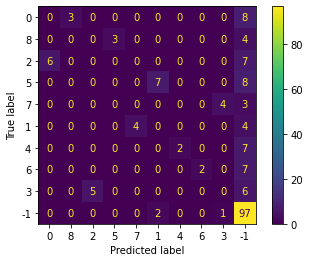

In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True, n_jobs=-1)
lof.fit(feature_train)

y_pred_lof = pd.Series(lof.predict(feature_test))
df_seen = pd.DataFrame(y_pred_proba, columns=y_train.unique())
df_seen['unseen'] = 0

y_pred = df_seen.idxmax(axis=1)
y_pred[y_pred_lof[y_pred_lof==-1].index]=-1
cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
accuracy_score(y_pred,y_test)

Ale omijając wyniki klasyfikatora dla 9 klas..

W zbiorze testowym znajduje się 100 anomalii - 97 zostało dobrze sklasyfikowanych

In [ ]:
test_data[0]

array([[   5, 2812,  225, ...,    0,    0,    0],
       [ 119,  262,   85, ...,    0,    0,    0],
       [3343,   31,   38, ...,    0,    0,    0],
       ...,
       [  65, 1072,  595, ...,    0,    0,    0],
       [5862,    9,    4, ...,    0,    0,    0],
       [5863,    9,   30, ...,    0,    0,    0]], dtype=int32)

In [ ]:
y_pred_proba = model.predict(test_data[0])
y_pred_proba_train = model.predict(train_data[0])
classes = y_test.unique()
method = 'LOF (LMCL)'
get_deep_feature = Model(inputs=model.input, 
                         outputs=model.layers[-3].output)
feature_test = get_deep_feature.predict(test_data[0])
feature_train = get_deep_feature.predict(train_data[0])

In [ ]:
y_pred_proba

array([[0.10359517, 0.12320057, 0.08046834, ..., 0.09808845, 0.09907207,
        0.09164179],
       [0.09188161, 0.0885434 , 0.08768825, ..., 0.11534724, 0.08752667,
        0.20406902],
       [0.10766008, 0.1670118 , 0.19145626, ..., 0.07849938, 0.09173696,
        0.10640532],
       ...,
       [0.08546976, 0.10476092, 0.07939428, ..., 0.09554262, 0.12921678,
        0.09794468],
       [0.06636148, 0.17385319, 0.13798696, ..., 0.12946413, 0.10169329,
        0.10159175],
       [0.10696699, 0.15286016, 0.09779482, ..., 0.09613074, 0.17020376,
        0.07969492]], dtype=float32)

0.5368421052631579

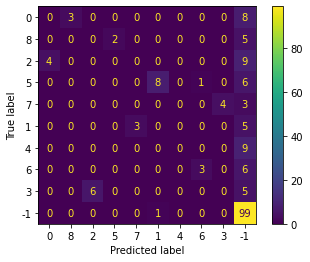

In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True, n_jobs=-1)
lof.fit(feature_train)

y_pred_lof = pd.Series(lof.predict(feature_test))
df_seen = pd.DataFrame(y_pred_proba, columns=y_train.unique())
df_seen['unseen'] = 0

y_pred = df_seen.idxmax(axis=1)
y_pred[y_pred_lof[y_pred_lof==-1].index]=-1
cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
accuracy_score(y_pred,y_test)

In [ ]:
cm[:9,:9]

array([[0, 3, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0],
       [4, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 8, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 4],
       [0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 6, 0, 0, 0, 0, 0, 0]])

In [ ]:
cm[:9,:9].sum()

34

In [ ]:
(34+99)/190

0.7

In [ ]:
cm[:9,9:].sum()

56

In [ ]:
cm[9:,:9].sum()

1

0.5368421052631579

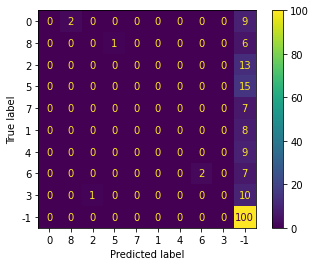

In [ ]:
lof = IsolationForest(n_estimators=95, max_samples=90, contamination=0.5, max_features=5, bootstrap=False, n_jobs=None,random_state=0)

lof.fit(feature_train)

y_pred_lof = pd.Series(lof.predict(feature_test))
df_seen = pd.DataFrame(y_pred_proba, columns=y_train.unique())
df_seen['unseen'] = 0

y_pred = df_seen.idxmax(axis=1)
y_pred[y_pred_lof[y_pred_lof==-1].index]=-1
cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
accuracy_score(y_pred,y_test)

-------------

In [ ]:
X_train = vc.make_vectors(text_train.values)
X_val = vc.make_vectors(text_val.values)

X_test0 = vc.make_vectors(text_test0.values)
X_outliers = vc.make_vectors(data_an['comment'].values)

#test set = (X_test + y_test) + anomaly class
X_test = np.vstack([X_test0, X_outliers]) 
y_test = pd.concat([y_test0,data_an['label']])
db_y_test = pd.concat([db_test,data_an['label']])

NameError: ignored

# Preprocessing


In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
X_train = vc.make_vectors(text_train.values)
X_test0 = vc.make_vectors(text_test0.values)
X_outliers = vc.make_vectors(data_an['comment'].values)

In [ ]:
X_train

array([[ 0.0686191 ,  0.08219691,  0.01634696, ..., -0.05590384,
         0.0275783 , -0.0225623 ],
       [-0.03398514,  0.05371666, -0.09219408, ...,  0.01417923,
        -0.03765583, -0.02503967],
       [ 0.02618408,  0.08276367,  0.105399  , ..., -0.09319197,
         0.02408273, -0.01593889],
       ...,
       [ 0.06313833,  0.0006307 ,  0.00173314, ..., -0.05719121,
        -0.01654243, -0.01771037],
       [ 0.07774135,  0.02988652,  0.01478468, ..., -0.06413814,
         0.06386239, -0.03085763],
       [ 0.03764461,  0.04586088,  0.06161675, ..., -0.08593779,
         0.04104614, -0.03659762]], dtype=float32)

In [ ]:
#test set = (X_test + y_test) + anomaly class
X_test = np.vstack([X_test0, X_outliers]) 
y_test = pd.concat([y_test0,data_an['label']])
db_y_test = pd.concat([db_test,data_an['label']])

In [ ]:
y_test

In [ ]:
db_y_test.shape

(190,)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=2, contamination=0.1, novelty=True)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

0.9864197530864197
0.5894736842105263
0.4965817277812306
0.563912429378531


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=2, contamination=0.2, novelty=True)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

0.9654320987654321
0.6526315789473685
0.49120603015075376
0.6460027100271002


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=2, contamination=0.5, novelty=True)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

0.7753086419753087
0.7
0.4367176634214186
0.693816968703175


# threshhold for std - one class learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [ ]:
class StdThresholdClassifier():
    def __init__(self, train, threshold=0.15, clf=LogisticRegression(C = 9)):
        self._clf = clf
        self._threshold = threshold
        self._train = train
        
    def fit(self, X_train):
         self._clf.fit(X_train, self._train)
            
    def predict(self, X):
        return [1 if np.std(probs) < self._threshold else -1 for probs in self._clf.predict_proba(X)]

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
clf = StdThresholdClassifier(y_train, 0.15, clf=LogisticRegression(C = 9))
clf.fit(X_train)

y_pred_train = clf.predict(np.array(X_train))
y_pred_test = clf.predict(np.array(X_test))
print(accuracy_score(y_pred_train,y_train))
print(accuracy_score(y_pred_test,y_test))

ValueError: ignored

In [ ]:
from keras.layers import LSTM
from keras.layers import Bidirectional
class NN(Model):

  def __init__(self):
    super().__init__()
    self.clf = Sequential([
      Bidirectional(LSTM(60, activation='relu',return_sequences=True)),
      Dropout(0.5),
      Bidirectional(LSTM(300, activation='relu',return_sequences=True)),
      Dropout(0.5),
      Bidirectional(LSTM(15, activation='relu')),
      Dropout(0.5),
      Dense(9, activation='sigmoid')
    ])

  def call(self, inputs):
    prob = self.clf(inputs)
    return prob

#Best model -acc:85%

In [ ]:

from keras.layers import LSTM
from keras.layers import Bidirectional
class NN(Model):

  def __init__(self):
    super().__init__()
    self.clf = Sequential([
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(60,activation='relu',return_sequences=True)),
      Dropout(0.5),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(300,activation='relu',return_sequences=True)),
      Dropout(0.5),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(15,activation='relu')),
      Dropout(0.5),
      Dense(9, activation='sigmoid')
    ])

  def call(self, inputs):
    prob = self.clf(inputs)
    return prob

keep testing

In [ ]:
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
class NN(Model):

  def __init__(self):
    super().__init__()
    self.clf = Sequential([
      Conv1D(256, 14,strides=4, padding='causal', activation='relu'),
      Conv1D(256, 14,strides=4, padding='causal', activation='relu'),
      Bidirectional(LSTM(256, activation='relu',return_sequences=True)),
      Dropout(0.5),
      Dense(9, activation='sigmoid')
    ])

  def call(self, inputs):
    prob = self.clf(inputs)
    return prob
model = NN()
# reshape inputs for LSTM [samples, timesteps, features]
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
print("Test data shape:", X_val.shape)
# configurations of model
model.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer='rmsprop')

history = model.fit(
    X_train2,
    y_train,
    epochs=200,
    batch_size=200,
    validation_data=(X_val2,y_val)
)

In [ ]:


from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
class NN(Model):

  def __init__(self):
    super().__init__()
    self.clf = Sequential([
      Conv1D(256, 14,strides=4, padding='causal', activation='relu'),
      Conv1D(256, 14,strides=4, padding='causal', activation='relu'),
      Dense(256, activation='relu'),
      Dropout(0.5),
      Dense(9, activation='sigmoid')
    ])

  def call(self, inputs):
    prob = self.clf(inputs)
    return prob
model = NN()
# reshape inputs for LSTM [samples, timesteps, features]
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
print("Test data shape:", X_val.shape)
# configurations of model
model.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer='rmsprop')

history = model.fit(
    X_train2,
    y_train,
    epochs=200,
    batch_size=200,
    validation_data=(X_val2,y_val)
)

In [ ]:


from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
class NN(Model):

  def __init__(self):
    super().__init__()
    self.clf = Sequential([
      Conv1D(128, 7,strides=3, padding='causal', activation='relu'),
      Conv1D(128, 7,strides=3, padding='causal', activation='relu'),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(9, activation='sigmoid')
    ])

  def call(self, inputs):
    prob = self.clf(inputs)
    return prob
model = NN()
# reshape inputs for LSTM [samples, timesteps, features]
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
print("Test data shape:", X_val.shape)
# configurations of model
model.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer='rmsprop')

history = model.fit(
    X_train2,
    y_train,
    epochs=200,
    batch_size=200,
    validation_data=(X_val2,y_val)
)

In [ ]:

from keras.layers import LSTM
from keras.layers import Bidirectional
class NN(Model):

  def __init__(self):
    super().__init__()
    self.clf = Sequential([
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(60,activation='relu',return_sequences=True)),
      Dropout(0.5),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(300,activation='relu',return_sequences=True)),
      Dropout(0.5),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(300,activation='relu',return_sequences=True)),
      Dropout(0.5),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(15,activation='relu')),
      Dropout(0.5),
      Dense(9, activation='sigmoid')
    ])

  def call(self, inputs):
    prob = self.clf(inputs)
    return prob
model = NN()
# reshape inputs for LSTM [samples, timesteps, features]
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
print("Test data shape:", X_val.shape)
# configurations of model
model.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer='rmsprop')

history = model.fit(
    X_train2,
    y_train,
    epochs=200,
    batch_size=200,
    validation_data=(X_val2,y_val)
)

In [ ]:
class std_threshold_NN():
    def __init__(self, train, threshold=0.23, clf=NN()):
        self._clf = clf
        self._threshold = threshold
        self._train = train
        
    def fit(self, X_train):
         self._clf.fit(X_train, self._train ,epochs=200, batch_size=512)
            
    def predict2(self, X):
        return [1 if np.std(probs) < self._threshold else -1 for probs in self._clf.predict(X)]

    def probs(self, X):
        return self._clf.predict(X)

    def std(self, X):
        return np.std(self._clf.predict(X))

In [ ]:
y_pred_train = clf.predict2(np.array(X_train))

In [ ]:
print(np.std(clf.predict(X_test)))

In [ ]:
# model=NN()
class std_threshold_NN():
    def __init__(self, train, threshold=0.23, clf=NN()):
        self._clf = clf
        self._threshold = threshold
        self._train = train
        
    def fit(self, X_train):
         self._clf.fit(X_train, self._train ,epochs=200, batch_size=512)
            
    def predict2(self, X):
        return [1 if np.std(probs) < self._threshold else -1 for probs in self._clf.predict(X)]

    def probs(self, X):
        return self._clf.predict(X)

    def std(self, X):
        return np.std(self._clf.predict(X))

clf = std_threshold_NN(y_train, 0.01, clf=model)
model.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer='Adam')
clf.fit(X_train)

y_pred_train = clf.predict2(np.array(X_train))
y_pred_test = clf.predict2(np.array(X_test))
print(accuracy_score(y_pred_train,y_train))
print(accuracy_score(y_pred_test,y_test))

In [ ]:
x_train_scaled = X_train
x_test_scaled = X_test

In [ ]:
model = NN()
# reshape inputs for LSTM [samples, timesteps, features]
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
print("Test data shape:", X_val.shape)
# configurations of model
model.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer='rmsprop')

history = model.fit(
    X_train2,
    y_train,
    epochs=200,
    batch_size=200,
    validation_data=(X_val2,y_val)
)

##**Autoencoder()** 

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [ ]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
x_train_scaled = X_train
x_test_scaled = X_test

In [ ]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
2/2 [==============================] - 3s 408ms/step - loss: 0.1464 - mse: 0.2588 - val_loss: 0.1461 - val_mse: 0.2577
Epoch 2/20
2/2 [==============================] - 0s 51ms/step - loss: 0.1461 - mse: 0.2582 - val_loss: 0.1457 - val_mse: 0.2570
Epoch 3/20
2/2 [==============================] - 0s 64ms/step - loss: 0.1458 - mse: 0.2575 - val_loss: 0.1453 - val_mse: 0.2562
Epoch 4/20
2/2 [==============================] - 0s 49ms/step - loss: 0.1453 - mse: 0.2567 - val_loss: 0.1448 - val_mse: 0.2552
Epoch 5/20
2/2 [==============================] - 0s 68ms/step - loss: 0.1448 - mse: 0.2556 - val_loss: 0.1442 - val_mse: 0.2539
Epoch 6/20
2/2 [==============================] - 0s 55ms/step - loss: 0.1441 - mse: 0.2543 - val_loss: 0.1433 - val_mse: 0.2523
Epoch 7/20
2/2 [==============================] - 0s 51ms/step - loss: 0.1432 - mse: 0.2525 - val_loss: 0.1422 - val_mse: 0.2500
Epoch 8/20
2/2 [==============================] - 0s 54ms/step - loss: 0.1419 - mse: 0.2500 - va

In [ ]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  print(errors.dtype)
  print(errors)
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else -1)
  return preds

In [ ]:
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, x_train_scaled)
print(f"Threshold method two: {threshold_2}")

Threshold method one: 0.020182466134428978
Threshold method two: 0.022571505326777697


In [ ]:
y_test

70     1
827    1
231    1
588    1
39     1
      ..
95    -1
96    -1
97    -1
98    -1
99    -1
Name: label, Length: 190, dtype: int64

In [ ]:
preds = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds, y_test)

<dtype: 'float32'>
tf.Tensor(
[0.02126688 0.01604506 0.01465875 0.01245676 0.03121058 0.0147031
 0.01645912 0.01305681 0.01597319 0.01580039 0.01809939 0.01548968
 0.01332784 0.02355714 0.01598155 0.01442608 0.01546012 0.01582009
 0.01809993 0.01880593 0.01487795 0.01344955 0.0202638  0.01940164
 0.0152726  0.01249714 0.01664067 0.01608166 0.02232843 0.01658733
 0.02076385 0.01124507 0.01500547 0.01337271 0.02377196 0.01504018
 0.0168625  0.01390202 0.0122798  0.01653306 0.01447157 0.02452421
 0.01420862 0.01966073 0.01883323 0.01284761 0.01407814 0.01570755
 0.01234338 0.01727765 0.01803268 0.01312866 0.01480115 0.02072767
 0.01923663 0.01558571 0.02015411 0.01893443 0.02160785 0.01626897
 0.02749488 0.01863675 0.01273244 0.01501124 0.02069785 0.01431264
 0.02049097 0.01406085 0.01602106 0.01640257 0.01169121 0.01619008
 0.01970334 0.01619864 0.01928134 0.01735893 0.01389722 0.01753124
 0.02100851 0.01474149 0.01414941 0.02232829 0.0149743  0.02064014
 0.01614318 0.01728777 0.01795758

0.5578947368421052

In [ ]:
# create a model by subclassing Model class in tensorflow
x_train_scaled = X_train
x_test_scaled = X_test
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=4):
    super().__init__()
    self.encoder = Sequential([
      Dense(200, activation='relu'),
      Dropout(0.5),
      Dense(100, activation='relu'),
      Dropout(0.1),
      Dense(30, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(30, activation='relu'),
      Dropout(0.1),
      Dense(100, activation='relu'),
      Dropout(0.1),
      Dense(200, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled))

In [ ]:
model.predict(x_train_scaled).shape

In [ ]:
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, x_train_scaled)
print(f"Threshold method two: {threshold_2}")
preds = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds, y_test)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

In [ ]:
# define the autoencoder network model
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(60, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(60, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
# fit the model to the data
nb_epochs = 20
batch_size = 100
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

In [ ]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mse(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mse(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = np.array(model.predict(x_test_scaled))
  # provides losses of individual instances
  errors = tf.keras.losses.mse(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  errors=np.array(errors).reshape(errors.shape[0],)
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else -1)
  return preds

In [ ]:
threshold = find_threshold(model, X_train)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, X_train)
print(f"Threshold method two: {threshold_2}")
preds = get_predictions(model, X_test, threshold)
accuracy_score(preds, y_test)

In [ ]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(150, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(50, activation='relu', return_sequences=True)(L1)
    L3 = LSTM(10, activation='relu', return_sequences=False)(L2)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(10, activation='relu', return_sequences=True)(L4)
    L6 = LSTM(50, activation='relu', return_sequences=True)(L5)
    L7 = LSTM(150, activation='relu', return_sequences=True)(L6)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

nb_epochs = 20
batch_size = 100
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

threshold = find_threshold(model, X_train)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, X_train)
print(f"Threshold method two: {threshold_2}")
preds = get_predictions(model, X_test, threshold)
accuracy_score(preds, y_test)

In [ ]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=True)(L1)
    L3 = LSTM(10, activation='relu', return_sequences=False)(L2)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(10, activation='relu', return_sequences=True)(L4)
    L6 = LSTM(16, activation='relu', return_sequences=True)(L5)
    L7 = LSTM(32, activation='relu', return_sequences=True)(L6)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

nb_epochs = 20
batch_size = 100
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

threshold = find_threshold(model, X_train)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, X_train)
print(f"Threshold method two: {threshold_2}")
preds = get_predictions(model, X_test, threshold)
accuracy_score(preds, y_test)

# Autoencoder on BERT embeddings

In [ ]:
!pip install tensorflow
!pip install tensorflow_text==2.8.2

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.0 MB/s 


In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']



In [ ]:
X_train = get_sentence_embeding(text_train.values)

In [ ]:
X_test0 = get_sentence_embeding(text_test0.values)
X_outliers = get_sentence_embeding(data_an['comment'].values)

In [ ]:
X_train = get_sentence_embeding(text_train.values)
X_val = get_sentence_embeding(text_val.values)

X_test0 = get_sentence_embeding(text_test0.values)
X_outliers = get_sentence_embeding(data_an['comment'].values)

#test set = (X_test + y_test) + anomaly class
X_test = np.vstack([X_test0, X_outliers]) 
y_test = pd.concat([y_test0,data_an['label']])

In [ ]:
#test set = (X_test + y_test) + anomaly class
X_test = np.vstack([X_test0, X_outliers]) 
y_test = pd.concat([y_test0,data_an['label']])


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(648, 768)
(190, 768)
(162, 768)


In [ ]:
X_train=X_train.numpy()
X_val=X_val.numpy()

In [ ]:
768/8

96.0

In [ ]:
from keras.layers import LSTM
from keras.layers import Bidirectional
class NN(Model):

  def __init__(self):
    super().__init__()
    self.clf = Sequential([
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(768,activation='relu',return_sequences=True)),
      Dropout(0.5),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(384,activation='relu',return_sequences=True)),
      Dropout(0.5),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(192,activation='relu')),
      Dropout(0.5),
      Dense(9, activation='sigmoid')
    ])

  def call(self, inputs):
    prob = self.clf(inputs)
    return prob

In [ ]:
model = NN()
# reshape inputs for LSTM [samples, timesteps, features]


X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
print("Test data shape:", X_val.shape)
# configurations of model
model.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer='rmsprop')

history = model.fit(
    X_train2,
    y_train,
    epochs=200,
    batch_size=200,
    validation_data=(X_val2,y_val))

Training data shape: (648, 768)
Test data shape: (162, 768)
Epoch 1/200
4/4 [==============================] - 13s 515ms/step - loss: 2.3601 - accuracy: 0.1373 - val_loss: 2.3164 - val_accuracy: 0.1049
Epoch 2/200
4/4 [==============================] - 1s 246ms/step - loss: 2.2471 - accuracy: 0.0988 - val_loss: 2.1944 - val_accuracy: 0.1111
Epoch 3/200
4/4 [==============================] - 1s 241ms/step - loss: 2.1999 - accuracy: 0.1373 - val_loss: 2.1916 - val_accuracy: 0.1111
Epoch 4/200
4/4 [==============================] - 1s 235ms/step - loss: 2.1906 - accuracy: 0.1204 - val_loss: 2.2054 - val_accuracy: 0.0802
Epoch 5/200
4/4 [==============================] - 1s 237ms/step - loss: 2.1838 - accuracy: 0.1281 - val_loss: 2.1837 - val_accuracy: 0.1173
Epoch 6/200
4/4 [==============================] - 1s 239ms/step - loss: 2.1889 - accuracy: 0.1111 - val_loss: 2.2062 - val_accuracy: 0.1111
Epoch 7/200
4/4 [==============================] - 1s 241ms/step - loss: 2.1862 - accuracy: 0

In [ ]:


from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
class NN(Model):

  def __init__(self):
    super().__init__()
    self.clf = Sequential([
      Conv1D(256, 14,strides=4, padding='causal', activation='relu'),
      Conv1D(256, 14,strides=4, padding='causal', activation='relu'),
      Dense(256, activation='relu'),
      Dropout(0.5),
      Dense(9, activation='sigmoid')
    ])

  def call(self, inputs):
    prob = self.clf(inputs)
    return prob
model = NN()
# reshape inputs for LSTM [samples, timesteps, features]
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
print("Test data shape:", X_val.shape)
# configurations of model
model.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer='rmsprop')

history = model.fit(
    X_train2,
    y_train,
    epochs=200,
    batch_size=200,
    validation_data=(X_val2,y_val)
)

Training data shape: (648, 768)
Test data shape: (162, 768)
Epoch 1/200
4/4 [==============================] - 3s 534ms/step - loss: 2.2562 - accuracy: 0.1127 - val_loss: 2.2066 - val_accuracy: 0.1605
Epoch 2/200
4/4 [==============================] - 2s 473ms/step - loss: 2.1995 - accuracy: 0.1250 - val_loss: 2.1860 - val_accuracy: 0.1420
Epoch 3/200
4/4 [==============================] - 2s 460ms/step - loss: 2.1851 - accuracy: 0.1404 - val_loss: 2.1801 - val_accuracy: 0.1358
Epoch 4/200
4/4 [==============================] - 2s 500ms/step - loss: 2.1827 - accuracy: 0.1327 - val_loss: 2.1911 - val_accuracy: 0.1420
Epoch 5/200
4/4 [==============================] - 2s 454ms/step - loss: 2.1648 - accuracy: 0.1512 - val_loss: 2.1613 - val_accuracy: 0.1790
Epoch 6/200
4/4 [==============================] - 3s 620ms/step - loss: 2.1458 - accuracy: 0.1651 - val_loss: 2.1528 - val_accuracy: 0.2037
Epoch 7/200
4/4 [==============================] - 2s 459ms/step - loss: 2.1402 - accuracy: 0.

In [ ]:
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
class NN(Model):

  def __init__(self):
    super().__init__()
    self.clf = Sequential([
      Dense(50, activation='relu'),
      Dropout(0.2),
      Dense(30, activation='relu'),
      Dropout(0.2),
      Dense(9, activation='sigmoid')
    ])

  def call(self, inputs):
    prob = self.clf(inputs)
    return prob
model = NN()
# reshape inputs for LSTM [samples, timesteps, features]
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
print("Test data shape:", X_val.shape)
# configurations of model
model.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    X_train2,
    y_train,
    epochs=400,
    batch_size=400,
    validation_data=(X_val2,y_val)
)

Training data shape: (648, 768)
Test data shape: (162, 768)
Epoch 1/400
2/2 [==============================] - 1s 209ms/step - loss: 2.3077 - accuracy: 0.1111 - val_loss: 2.1966 - val_accuracy: 0.1173
Epoch 2/400
2/2 [==============================] - 0s 28ms/step - loss: 2.2271 - accuracy: 0.1173 - val_loss: 2.1984 - val_accuracy: 0.1111
Epoch 3/400
2/2 [==============================] - 0s 25ms/step - loss: 2.2035 - accuracy: 0.1343 - val_loss: 2.2001 - val_accuracy: 0.1049
Epoch 4/400
2/2 [==============================] - 0s 26ms/step - loss: 2.1977 - accuracy: 0.1389 - val_loss: 2.1949 - val_accuracy: 0.1296
Epoch 5/400
2/2 [==============================] - 0s 27ms/step - loss: 2.2041 - accuracy: 0.1420 - val_loss: 2.1899 - val_accuracy: 0.1667
Epoch 6/400
2/2 [==============================] - 0s 24ms/step - loss: 2.1947 - accuracy: 0.1343 - val_loss: 2.1930 - val_accuracy: 0.1481
Epoch 7/400
2/2 [==============================] - 0s 25ms/step - loss: 2.1839 - accuracy: 0.1528 -

In [ ]:
class std_threshold_NN():
    def __init__(self, train, threshold=0.23, clf=NN()):
        self._clf = clf
        self._threshold = threshold
        self._train = train
        
    def fit(self, X_train):
         self._clf.fit(X_train, self._train ,epochs=200, batch_size=512)
            
    def predict2(self, X):
        return [1 if np.std(probs) < self._threshold else -1 for probs in self._clf.predict(X)]

    def probs(self, X):
        return self._clf.predict(X)

    def std(self, X):
        return np.std(self._clf.predict(X))

clf = std_threshold_NN(y_train,0.29, clf=model)
# model.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer='Adam')
# clf.fit(X_train)

y_pred_train = clf.predict2(np.array(X_train))
y_pred_test = clf.predict2(np.array(X_test))
print(accuracy_score(y_pred_train,y_train))
print(accuracy_score(y_pred_test,y_test))

0.0
0.48947368421052634


In [ ]:
clf.std(X_test)

0.3662708

In [ ]:
class StdThresholdClassifier():
    def __init__(self, train, threshold=0.15, clf=LogisticRegression(C = 9)):
        self._clf = clf
        self._threshold = threshold
        self._train = train
        
    def fit(self, X_train):
         self._clf.fit(X_train, self._train)
            
    def predict(self, X):
        return [1 if np.std(probs) < self._threshold else -1 for probs in self._clf.predict_proba(X)]

clf = StdThresholdClassifier(y_train,0.22, clf=LogisticRegression(C = 9, max_iter=500))
# model.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer='Adam')
clf.fit(X_train)

y_pred_train = clf.predict(np.array(X_train))
y_pred_test = clf.predict(np.array(X_test))
print(accuracy_score(y_pred_train,y_train))
print(accuracy_score(y_pred_test,y_test))

0.0
0.15789473684210525


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LSTM
from keras.layers import Bidirectional
class NN(Model):

  def __init__(self): 
    super().__init__()
    self.clf = Sequential([
      Bidirectional(LSTM(100, activation='relu',return_sequences=True)),
      Dropout(0.2),
      Bidirectional(LSTM(50, activation='relu',return_sequences=True)),
      Dropout(0.2),
      Bidirectional(LSTM(30, activation='relu')),
      Dropout(0.2),
      Dense(9, activation='sigmoid')
    ])

  def call(self, inputs):
    prob = self.clf(inputs)
    return prob
  def call(self, inputs):
    prob = self.clf(inputs)
    return prob
model = NN()
# reshape inputs for LSTM [samples, timesteps, features]
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
print("Test data shape:", X_val.shape)
# configurations of model
model.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    X_train2,
    y_train,
    epochs=400,
    batch_size=400,
    validation_data=(X_val2,y_val)
)

Training data shape: (648, 768)
Test data shape: (162, 768)
Epoch 1/400
2/2 [==============================] - 10s 806ms/step - loss: 2.1967 - accuracy: 0.1281 - val_loss: 2.1973 - val_accuracy: 0.1235
Epoch 2/400
2/2 [==============================] - 0s 53ms/step - loss: 2.1951 - accuracy: 0.1204 - val_loss: 2.1977 - val_accuracy: 0.1420
Epoch 3/400
2/2 [==============================] - 0s 49ms/step - loss: 2.1938 - accuracy: 0.1157 - val_loss: 2.1982 - val_accuracy: 0.1049
Epoch 4/400
2/2 [==============================] - 0s 53ms/step - loss: 2.1900 - accuracy: 0.1204 - val_loss: 2.1997 - val_accuracy: 0.1049
Epoch 5/400
2/2 [==============================] - 0s 58ms/step - loss: 2.1867 - accuracy: 0.1358 - val_loss: 2.2017 - val_accuracy: 0.1049
Epoch 6/400
2/2 [==============================] - 0s 50ms/step - loss: 2.1875 - accuracy: 0.1235 - val_loss: 2.1932 - val_accuracy: 0.0988
Epoch 7/400
2/2 [==============================] - 0s 52ms/step - loss: 2.1850 - accuracy: 0.1296 

In [ ]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
x_train_scaled = X_train
x_test_scaled = X_test

model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=100,
    validation_data=(x_test_scaled, x_test_scaled)
)

def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else -1)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, x_train_scaled)
print(f"Threshold method two: {threshold_2}")

preds = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds, y_test)

In [ ]:
# create a model by subclassing Model class in tensorflow
x_train_scaled = X_train
x_test_scaled = X_test
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=4):
    super().__init__()
    self.encoder = Sequential([
      Dense(200, activation='relu'),
      Dropout(0.5),
      Dense(100, activation='relu'),
      Dropout(0.1),
      Dense(30, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(30, activation='relu'),
      Dropout(0.1),
      Dense(100, activation='relu'),
      Dropout(0.1),
      Dense(200, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=100,
    validation_data=(x_test_scaled, x_test_scaled))

In [ ]:
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, x_train_scaled)
print(f"Threshold method two: {threshold_2}")

preds = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds, y_test)

In [ ]:
# create a model by subclassing Model class in tensorflow
x_train_scaled = X_train
x_test_scaled = X_test
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=4):
    super().__init__()
    self.encoder = Sequential([
      Dense(200, activation='relu'),
      Dropout(0.5),
      Dense(100, activation='relu'),
      Dropout(0.1),
      Dense(30, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(30, activation='relu'),
      Dropout(0.1),
      Dense(100, activation='relu'),
      Dropout(0.1),
      Dense(200, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=400,
    batch_size=150,
    validation_data=(x_test_scaled, x_test_scaled))

In [ ]:
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, x_train_scaled)
print(f"Threshold method two: {threshold_2}")

preds = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds, y_test)

In [ ]:
X_tr = X_train
X_te = X_test

In [ ]:
# define the autoencoder network model
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# reshape inputs for LSTM [samples, timesteps, features]
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

LSTM autoencoder

In [ ]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mse(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mse(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = np.array(model.predict(x_test_scaled))
  # provides losses of individual instances
  errors = tf.keras.losses.mse(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  errors=np.array(errors).reshape(errors.shape[0],)
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else -1)
  return preds

In [ ]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=True)(L1)
    L3 = LSTM(4, activation='relu', return_sequences=False)(L2)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(4, activation='relu', return_sequences=True)(L4)
    L6 = LSTM(16, activation='relu', return_sequences=True)(L5)
    L7 = LSTM(32, activation='relu', return_sequences=True)(L6)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

nb_epochs = 100
batch_size = 100
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

threshold = find_threshold(model, X_train)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, X_train)
print(f"Threshold method two: {threshold_2}")
preds = get_predictions(model, X_test, threshold)
accuracy_score(preds, y_test)

In [ ]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=True)(L1)
    L3 = LSTM(8, activation='relu', return_sequences=False)(L2)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(8, activation='relu', return_sequences=True)(L4)
    L6 = LSTM(16, activation='relu', return_sequences=True)(L5)
    L7 = LSTM(32, activation='relu', return_sequences=True)(L6)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

nb_epochs = 20
batch_size = 20
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

threshold = find_threshold(model, X_train)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, X_train)
print(f"Threshold method two: {threshold_2}")
preds = get_predictions(model, X_test, threshold)
accuracy_score(preds, y_test)

In [ ]:
from keras.layers import Bidirectional

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = Bidirectional(LSTM(32, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00)))(inputs)
    L2 = Bidirectional(LSTM(16, activation='relu', return_sequences=True))(L1)
    L3 = Bidirectional(LSTM(8, activation='relu', return_sequences=False))(L2)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = Bidirectional(LSTM(8, activation='relu', return_sequences=True))(L4)
    L6 = Bidirectional(LSTM(16, activation='relu', return_sequences=True))(L5)
    L7 = Bidirectional(LSTM(32, activation='relu', return_sequences=True))(L6)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

nb_epochs = 1000
batch_size = 100  
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

threshold = find_threshold(model, X_train)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, X_train)
print(f"Threshold method two: {threshold_2}")
preds = get_predictions(model, X_test, threshold)
accuracy_score(preds, y_test)

In [ ]:
preds = get_predictions(model, X_test, threshold_2)
accuracy_score(preds, y_test)

# Finding parameters for dbscan

In [ ]:
from sklearn.cluster import DBSCAN
nclusters = []
minPts = 3
for i in range(2, 200):
  dbscan=DBSCAN(eps=i/100,min_samples=minPts)
  dbscan.fit(X_train)
  labels = dbscan.labels_
  nclusters.append(np.max(labels)+1)

plt.plot([i/100 for i in range(2,200)],nclusters)
plt.xlabel('epsilon')
plt.ylabel('number of clusters')
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors
minPts =  195
neighbors = NearestNeighbors(n_neighbors=minPts)
neighbors_fit = neighbors.fit(X_train)
distances, indices = neighbors_fit.kneighbors(X_train)
dist = distances[:,minPts-1]
dist_sort = np.sort(dist)
plt.plot(dist_sort)

# Applying dbscan

In [ ]:
from sklearn.cluster import DBSCAN
epsilon = 1.25
minPts =3
clf=DBSCAN(eps=epsilon,min_samples=minPts).fit(X_train)

predict = clf.fit_predict(X_train)
predict2=  clf.fit_predict(X_test)
print('train: ',accuracy_score(predict, db_train))
print('test: ',accuracy_score(predict2, db_y_test))
print(f1_score(predict, db_train, average='macro'))
print(f1_score(predict2, db_y_test, average='macro'))

In [ ]:
from sklearn.cluster import DBSCAN
epsilon = 1.2
minPts =300
clf=DBSCAN(eps=epsilon,min_samples=minPts).fit(X_train)

predict = clf.fit_predict(X_train)
predict2=  clf.fit_predict(X_test)
print('train: ',accuracy_score(predict, db_train))
print('test: ',accuracy_score(predict2, db_y_test))
print(f1_score(predict, db_train, average='macro'))
print(f1_score(predict2, db_y_test, average='macro'))

In [ ]:
from sklearn.cluster import DBSCAN
epsilon = 2
minPts =300
clf=DBSCAN(eps=epsilon,min_samples=minPts).fit(X_train)

predict = clf.fit_predict(X_train)
predict2=  clf.fit_predict(X_test)
print('train: ',accuracy_score(predict, db_train))
print('test: ',accuracy_score(predict2, db_y_test))
print(f1_score(predict, db_train, average='macro'))
print(f1_score(predict2, db_y_test, average='macro'))

In [ ]:
from sklearn.cluster import DBSCAN
epsilon = 1.25
minPts =195
clf=DBSCAN(eps=epsilon,min_samples=minPts).fit(X_train)

predict = clf.fit_predict(X_train)
predict2=  clf.fit_predict(X_test)
print('train: ',accuracy_score(predict, db_train))
print('test: ',accuracy_score(predict2, db_y_test))
print(f1_score(predict, db_train, average='macro'))
print(f1_score(predict2, db_y_test, average='macro'))

In [ ]:
print(f1_score(predict, db_train, average='macro'))
print(f1_score(predict2, db_y_test, average='macro'))

In [ ]:
# results = pd.DataFrame({'clustered': [list(predict2)], 'label': [db_y_test]})

In [ ]:
columns = ['comment','vector','clustered', 'label']
results = pd.DataFrame(data=list(zip(text_test0, X_test0, predict2, db_y_test)),columns=columns)
results.head(60)

In [ ]:
len(dbscan.labels_)

In [ ]:
len(clf.labels_)

In [ ]:
dbscan.n_features_in_

# Isolation Forest

# Testing different parameters


In [ ]:
clf = IsolationForest(n_estimators=10, bootstrap=False,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
clf = IsolationForest(n_estimators=200, max_samples='auto', contamination='auto', max_features=1.0, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
clf = IsolationForest(n_estimators=200, max_samples=50, contamination='auto', max_features=1.0, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
clf = IsolationForest(n_estimators=200, max_samples=50, contamination=0.1, max_features=1.0, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

big difference (contamination 0.1 -> 0.5)

In [ ]:
clf = IsolationForest(n_estimators=200, max_samples=50, contamination=0.5, max_features=1.0, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
clf = IsolationForest(n_estimators=200, max_samples=50, contamination=0.5, max_features=5, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
clf = IsolationForest(n_estimators=150, max_samples=50, contamination=0.5, max_features=5, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
clf = IsolationForest(n_estimators=115, max_samples=50, contamination=0.5, max_features=5, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
clf = IsolationForest(n_estimators=115, max_samples=90, contamination=0.5, max_features=5, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
clf = IsolationForest(n_estimators=95, max_samples=90, contamination=0.5, max_features=5, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
clf = IsolationForest(n_estimators=95, max_samples=90, contamination=0.5, max_features=5, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
columns = ['comment','vector','clustered', 'label']
results = pd.DataFrame(data=list(zip(text_test0, X_test0, predict2, y_test)),columns=columns)
results.head()

In [ ]:
Xtrain

In [ ]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
# Set the figure size
plt.rcParams["figure.figsize"] = [7,7]
plt.rcParams["figure.autolayout"] = True

# Random data of 100×3 dimension
data = np.array(np.random.random((100, 3)))

# Scatter plot
plt.scatter(X_train[:, 0], X_train[:, 1], cmap='blue')

plt.scatter(X_test[:, 0], X_test[:, 1], cmap='red')

# Display the plot
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [5,5]
plt.rcParams["figure.autolayout"] = True

In [ ]:
from sklearn.cluster import DBSCAN
nclusters = []
minPts = 3
for i in range(2, 200):
  dbscan=DBSCAN(eps=i/100,min_samples=minPts)
  dbscan.fit(X_train)
  labels = dbscan.labels_
  nclusters.append(np.max(labels)+1)

plt.plot([i/100 for i in range(2,200)],nclusters)
plt.xlabel('epsilon')
plt.ylabel('number of clusters')
plt.show()


In [ ]:
from sklearn.neighbors import NearestNeighbors
minPts =  2
neighbors = NearestNeighbors(n_neighbors=minPts)
neighbors_fit = neighbors.fit(X_train)
distances, indices = neighbors_fit.kneighbors(X_train)
dist = distances[:,minPts-1]
dist_sort = np.sort(dist)
plt.plot(dist_sort)

In [ ]:
from sklearn.cluster import DBSCAN
epsilon = 1.25
minPts =195
clf=DBSCAN(eps=epsilon,min_samples=minPts).fit(X_train)

predict = clf.fit_predict(X_train)
predict2=  clf.fit_predict(X_test)
print('train: ',accuracy_score(predict, db_train))
print('test: ',accuracy_score(predict2, db_y_test))
print(f1_score(predict, db_train, average='macro'))
print(f1_score(predict2, db_y_test, average='macro'))

In [ ]:
from sklearn.cluster import DBSCAN
epsilon = 0.1
minPts =2
clf=DBSCAN(eps=epsilon,min_samples=minPts).fit(X_train)

predict = clf.fit_predict(X_train)
predict2=  clf.fit_predict(X_test)
print('train: ',accuracy_score(predict, db_train))
print('test: ',accuracy_score(predict2, db_y_test))
print(f1_score(predict, db_train, average='macro'))
print(f1_score(predict2, db_y_test, average='macro'))

metric: minkowski

In [ ]:
import scipy.spatial.distance

clf=DBSCAN(eps=epsilon,min_samples=minPts, metric='minkowski', p=1.5).fit(X_train)
epsilon = 0.1
minPts =2
predict = clf.fit_predict(X_train)
predict2=  clf.fit_predict(X_test)
print('train: ',accuracy_score(predict, db_train))
print('test: ',accuracy_score(predict2, db_y_test))

In [ ]:
clf=DBSCAN(eps=epsilon,min_samples=minPts, metric='minkowski', p=2).fit(X_train)
epsilon = 0.1
minPts =2
predict = clf.fit_predict(X_train)
predict2=  clf.fit_predict(X_test)
print('train: ',accuracy_score(predict, db_train))
print('test: ',accuracy_score(predict2, db_y_test))

In [ ]:
clf=DBSCAN(eps=epsilon,min_samples=minPts, metric='minkowski', p=3.5).fit(X_train)
epsilon = 0.1
minPts =2
predict = clf.fit_predict(X_train)
predict2=  clf.fit_predict(X_test)
print('train: ',accuracy_score(predict, db_train))
print('test: ',accuracy_score(predict2, db_y_test))

In [ ]:
clf=DBSCAN(eps=epsilon,min_samples=minPts, metric='minkowski', p=4.5).fit(X_train)
epsilon = 0.1
minPts =2
predict = clf.fit_predict(X_train)
predict2=  clf.fit_predict(X_test)
print('train: ',accuracy_score(predict, db_train))
print('test: ',accuracy_score(predict2, db_y_test))

In [ ]:
clf=DBSCAN(eps=epsilon,min_samples=minPts, metric='minkowski', p=5).fit(X_train)
epsilon = 0.1
minPts =2
predict = clf.fit_predict(X_train)
predict2=  clf.fit_predict(X_test)
print('train: ',accuracy_score(predict, db_train))
print('test: ',accuracy_score(predict2, db_y_test))

In [ ]:
clf=DBSCAN(eps=epsilon,min_samples=minPts, metric='minkowski', p=1).fit(X_train)
epsilon =0.1
minPts =3
predict = clf.fit_predict(X_train)
predict2=  clf.fit_predict(X_test)
print('train: ',accuracy_score(predict, db_train))
print('test: ',accuracy_score(predict2, db_y_test))

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=predict2)
plt.show()

In [ ]:
columns = ['clustered', 'label']
results = pd.DataFrame(data=list(zip( predict2, db_y_test)),columns=columns)
results.head(5)

In [ ]:
results['label'].value_counts()

In [ ]:
results['clustered'].value_counts()

In [ ]:
results.shape

In [ ]:
db_y_test.shape
predict2.shape

In [ ]:
clf = IsolationForest(n_estimators=95, max_samples=90, contamination=0.5, max_features=2, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
clf = IsolationForest(n_estimators=15, max_samples='auto', contamination='auto', max_features=1, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
clf = IsolationForest(n_estimators=15, max_samples='auto', contamination=0.1, max_features=1, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
clf = IsolationForest(n_estimators=15, max_samples='auto', contamination=0.19, max_features=1, bootstrap=False, n_jobs=None,random_state=0)

clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score( y_pred_test, y_test))
print(f1_score(y_pred_train, y_train, average='macro'))
print(f1_score(y_pred_test, y_test, average='macro'))

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test)
plt.show()

In [ ]:
columns = ['clustered', 'label']
results = pd.DataFrame(data=list(zip( y_pred_test, y_test)),columns=columns)
results.head(5)

In [ ]:
results['label'].value_counts()

In [ ]:
results['clustered'].value_counts()

In [ ]:
#metric: minkowski
#opisać problem wielowymiarowosci w pracy i opisać dbscan 

In [ ]:
#random search

In [ ]:
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import make_scorer, f1_score
# from sklearn import model_selection
# from sklearn.datasets import make_classification

# X_train, y_train = make_classification(n_samples=500, 
#                                        n_classes=2)

# clf = IsolationForest(random_state=47 )

# param_grid = {'n_estimators': list(range(1, 801, 50)), 
#               'max_samples': list(range(1, 501, 50)), 
#               'contamination': ['auto', 0.1, 0.2, 0.3, 0.4, 0.5], 
#               'max_features': [1, 3, 5, 10, 15],  
#               'n_jobs': [None, 2, 5, 10, 20, 30]}


# f1sc = make_scorer(f1_score, average='micro')
# grid_dt_estimator = model_selection.GridSearchCV(clf, 
#                                                  param_grid,
#                                                  scoring=f1sc, 
#                                                  refit=True,
#                                                  cv=10, 
#                                                  return_train_score=True)
# grid_dt_estimator.fit(X_train, y_train)